<a href="https://colab.research.google.com/github/mtedder/AI-ML-Workshop/blob/master/notebooks/xor_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#XOR Keras Project

[Ref Docs 1](https://blog.thoughtram.io/machine-learning/2016/11/02/understanding-XOR-with-keras-and-tensorlow.html)

[Ref Docs 2](https://github.com/brianschardt/xor_keras_tensorflow_serving/blob/master/index.py)

![alt text](https://image.slidesharecdn.com/electroniccircuits-090706070731-phpapp01/95/electronic-circuits-32-728.jpg?cb=1246864077)

In [0]:
#Uncommet this code if you need colboratory tensorflow version to match the versions available in google Cloud ML. NOT required for this example
#!pip install tensorflow==1.12.0

##1. Imports

In [2]:
import os
import tensorflow as tf

import os
#import tensorflow as tf
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from tensorflow import keras

from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants, signature_constants, signature_def_utils_impl, utils

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD #Stochastic gradient descent optimizer

import matplotlib.pyplot as plt

Using TensorFlow backend.


##Version Info

In [0]:
#!python --version
# print("Tensorflow version" + tf.__version__)

##2. Data Preparation
Ref:

In [0]:
#Exhaustion of Different Possibilities
X = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
])

##3. Feature Extraction
Ref:

In [5]:
#Create dataframe version of x (features) from np array
x_df = pd.DataFrame({'x1':X[:,0],'x2':X[:,1]})
print(x_df)

#Return values of the different inputs
Y = np.array([[0],[1],[1],[0]])

#Create dataframe version of x (labels)
y_df = pd.DataFrame({'y':Y[:,0]})
print(y_df)

   x1  x2
0   0   0
1   0   1
2   1   0
3   1   1
   y
0  0
1  1
2  1
3  0


##4. Build Model
Ref:
![Example Model](https://i.stack.imgur.com/S52yR.png)

In [6]:
#https://www.tensorflow.org/api_docs/python/tf/metrics/accuracy
#https://www.tensorflow.org/api_docs/python/tf/keras/models
#https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential
#Specify the type of layers to use Densely-connected layer class - https://www.tensorflow.org/api_docs/python/tf/layers/Dense
#SGD - https://keras.io/optimizers/
#https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#compile
#https://keras.io/backend/#using-the-abstract-keras-backend-to-write-new-code
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
K.set_learning_phase(0) #all new operations will be in test mode from now on - The learning phase flag is a bool tensor (0 = test, 1 = train) to be passed as input to any Keras function that uses a different behavior at train time and test time

#Create XOR Model
#Create Model
#Model - groups layers into an object with training and inference features.
#Sequential - Linear stack of layers.
model = Sequential()
model.add(Dense(8, input_dim=2))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
sgd = SGD(lr=0.1)
#binary_accuracy = the frequency with which predictions matches labels
model.compile(loss='mse', optimizer=sgd, metrics=['binary_accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


##5. Train Model
Ref:

In [7]:
#Call the model.fit function
#Train using fit which Trains the model for a fixed number of epochs (iterations on a dataset) - https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#fit
epoch = 500 ## the higher this number is the more accurate the prediction will be 10000 is a good number to set it at just takes a while to train
history = model.fit(x_df, y_df, batch_size=1, nb_epoch=epoch)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/500
4/4 [==============================] - 0s 103ms/step - loss: 0.2658 - binary_accuracy: 0.5000
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2651 - binary_accuracy: 0.5000
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2638 - binary_accuracy: 0.5000
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2628 - binary_accuracy: 0.5000
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2621 - binary_accuracy: 0.7500
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2610 - binary_accuracy: 0.7500
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2601 - binary_accuracy: 0.5000
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2589 - binary_accuracy: 0.5000
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2583 - binary_accuracy: 0.7500
Epoch 10/500
4/4 [==============================] - 0s 2ms/ste

##6. Evaluate Model

In [8]:
#Visualize the model's training progress
#History.history attribute is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable)
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,binary_accuracy,loss,epoch
495,1.0,0.006776,495
496,1.0,0.006752,496
497,1.0,0.006728,497
498,1.0,0.006704,498
499,1.0,0.006680,499


['loss', 'binary_accuracy']
Testing Loss/Error:  0.01 Out


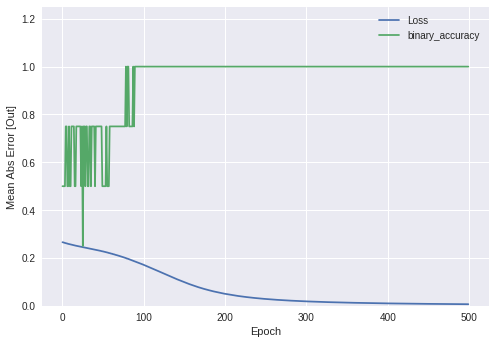

In [11]:
import matplotlib.pyplot as plt
#Is this model good? Visualize model performance,
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [Out]')

plt.plot(hist['epoch'], hist['loss'], label='Loss')

plt.plot(hist['epoch'], hist['binary_accuracy'], label = 'binary_accuracy')
plt.legend()
plt.ylim([0,1.25])

"#Test model using the test data and evaluate\n",
"#Returns the loss value & metrics values for the model in test mode - https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#evaluate\n",
print(model.metrics_names)
loss, ba = model.evaluate(x_df, y_df, verbose=0)
print("Testing Loss/Error: {:5.2f} Out".format(loss))

##7. Inference – Make Predictions

In [12]:
#Skip this step for model serving
#Use test data to make predictions on trained model
#Predict Generates output predictions for the input sample - https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#predict
#Then flatten numpy array result - https://www.tutorialspoint.com/numpy/numpy_ndarray_flatten.htm
test_df = pd.DataFrame({'x1':[0.0,0.0, 1.0, 1.0],'x2':[0.0,1.0, 0.0, 1.0]})
print ('Results of Model', model.predict(test_df).round())

Results of Model [[0.]
 [1.]
 [1.]
 [0.]]


#Deploy to ML Cloud Engine

##8. Prepare Model for Saving

In [13]:
# !rm -rf 1
model.input
model.output

<tf.Tensor 'activation_2/Sigmoid:0' shape=(?, 1) dtype=float32>

In [14]:
# Constants
#https://www.tensorflow.org/guide/low_level_intro
model_version = "1" #Change this to export different model versions, i.e. 2, ..., 7

#setting values for the sake of saving the model in the proper format
# http://amygdala.github.io/ml/tensorflow/cloud_ml_engine/2018/01/26/tf.html
x = model.input
y = model.output

prediction_signature = tf.saved_model.signature_def_utils.predict_signature_def({"inputs":x}, {"prediction":y}) #for XOR model

# valid_prediction_signature = tf.saved_model.signature_def_utils.is_valid_signature(prediction_signature)
# if(valid_prediction_signature == False):
#     raise ValueError("Error: Prediction signature not valid!")

builder = saved_model_builder.SavedModelBuilder('./'+ model_version)
#legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
#legacy_init_op = tf.group(tf.global_variables_initializer(), name='legacy_init_op')
#legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')

#Add the meta_graph and the variables to the builder
#RefL https://www.tensorflow.org/api_docs/python/tf/saved_model/Builder#add_meta_graph
#https://www.tensorflow.org/versions/r1.12/api_docs/python/tf/saved_model/main_op
builder.add_meta_graph_and_variables(
      sess, [tag_constants.SERVING],
      signature_def_map={
           signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature,
      },
      main_op=tf.tables_initializer())
      #legacy_init_op=legacy_init_op)

# save the graph
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./1/saved_model.pb


b'./1/saved_model.pb'

##9. Upload model to existing GCS bucket

In [0]:
#https://colab.research.google.com/notebooks/io.ipynb#scrollTo=xM70QWdxeE7q
from google.colab import auth
auth.authenticate_user()

# Existing bucket name
# (GCS buckets are part of a single global namespace.)
bucket_name = ''  #INSERT YOUR BUCKET NAME HERE!!

# Copy the model directory to our new bucket.
# Full reference: https://cloud.google.com/storage/docs/gsutil/commands/cp
!gsutil cp -r 1/. gs://{bucket_name}/

##Upload GOOGLE_APPLICATION_CREDENTIALS


In [0]:
#Upload GOOGLE_APPLICATION_CREDENTIALS json file from local computer and save to this notebook
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

##Set GOOGLE_APPLICATION_CREDENTIALS environment variable

In [0]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '' #INSERT YOUR CREDENTIALS FILENAME HERE!!

##10. Request online prediction from deployed model

In [0]:
import googleapiclient 
from googleapiclient import discovery
from googleapiclient import errors

#Setup online cloud model
#https://cloud.google.com/ml-engine/docs/tensorflow/online-predict#requesting_predictions
#https://cloud.google.com/ml-engine/docs/v1/predict-request
# https://cloud.google.com/ml-engine/docs/tensorflow/python-client-library
#https://www.raspberrypi.org/magpi/tensorflow-ai-raspberry-pi/
#https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.98614&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false
#https://stackoverflow.com/questions/45705070/how-to-load-and-use-a-saved-model-on-tensorflo


# Create the ML Engine service object.
# To authenticate set the environment variable
# GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
#name = 'projects/{}/models/{}'.format(Project ID,  MODEL_NAME)
service = googleapiclient.discovery.build('ml', 'v1')
name = 'projects/{}/models/{}'.format(Project ID,  MODEL_NAME) #INSERT YOUR PROJECT ID AND NAME HERE!!

#if version is not None:
name += '/versions/{}'.format(MODEL_VERSION_NAME) #INSERT YOUR MODEL VERSION NAME HERE!!
#name += '/versions/{}'.format('XOR_Version_1')
 
print(name)

response = service.projects().predict(
    name=name,    
    body={"instances": [{"inputs": [1.0,1.0]}, {"inputs": [0.0,0.0]}, {"inputs": [1.0,0.0]}]} #this WORKS! with the XOR model
).execute()

# if 'error' in response:
#     raise RuntimeError(response['error'])
response
#np.round(response['predictions'][0]['prediction'])
#response['predictions'][0]['prediction']

projects/mltest-229502/models/MpgModel/versions/XORV1


{'predictions': [{'prediction': [0.014323404990136623]},
  {'prediction': [0.004028792958706617]},
  {'prediction': [0.9865555763244629]}]}